In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import pyproj

In [ ]:
#Load data
path='/content/drive/Shareddrives/Coastal/FFT challenge/'
data = pd.read_csv(path+'data_delta.txt',delimiter=' ')
data = data.dropna() #Drop values with NAN values

In [ ]:
# Separate train and test, features and labels
train_dataset = data.sample(frac=0.8,random_state=1)
test_dataset = data.drop(train_dataset.index)

lbl = ['dx','dy']

train_labels = pd.DataFrame([train_dataset.pop(x) for x in lbl]).T
test_labels  = pd.DataFrame([test_dataset.pop(x) for x in lbl]).T

In [ ]:
# Normalization
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()
def norm(x):
    return(x-train_stats['mean'])/train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [ ]:
# Build Model
def build_model():
    model = keras.Sequential([
        layers.Dense(512,activation = tf.nn.relu, input_shape=[len(train_dataset.keys())]),
        layers.Dense(512, activation = tf.nn.relu),
        layers.Dense(256, activation = tf.nn.relu),
        layers.Dense(2)
        ])
    
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    
    model.compile(loss='mse',
                  optimizer = optimizer,
                  metrics =['mae', 'mse'])
    return model

model = build_model()
model.summary()

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               5120      
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 2)                 514       
                                                                 
Total params: 399,618
Trainable params: 399,618
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Runing the model

EPOCHS=1000

history = model.fit(
    normed_train_data, train_labels,
    epochs=EPOCHS, validation_split = 0.2, verbose=0)


hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
print(hist.tail())


Testing set Mean Abs Error: 131.19 m


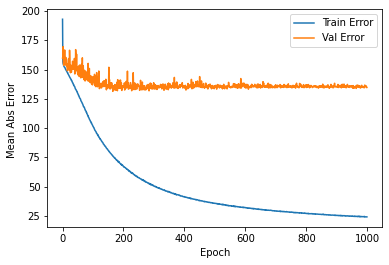

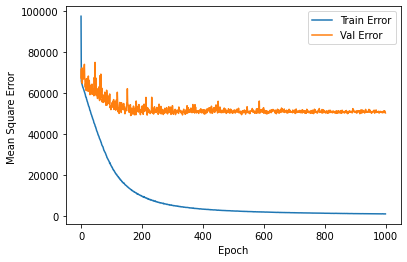

In [ ]:
#Testing the model

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error ')
    plt.plot(hist['epoch'],hist['mae'],
              label='Train Error')
    plt.plot(hist['epoch'],hist['val_mae'],
              label='Val Error')
    plt.legend()
    #plt.ylim([0,200.0])
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error ')
    plt.plot(hist['epoch'],hist['mse'],
              label='Train Error')
    plt.plot(hist['epoch'],hist['val_mse'],
              label='Val Error')
    plt.legend()
    #plt.ylim([0,250])

plot_history(history)

loss, mae, mse = model.evaluate(normed_test_data,test_labels,verbose=0)
print("Testing set Mean Abs Error: {:5.2f} m".format(mae))

In [ ]:
Data = pd.read_csv(path+'data_delta_SPOT-1257.txt',delimiter=' ')
Data = Data.dropna() #Drop values with NAN values
# #Separating data Train and Test, features and labels
lbl = ['dx','dy']
for x in lbl:
  Data.pop(x)
Normed_data = norm(Data)
print(Normed_data.shape)
preds=[]
for i in range(len(Normed_data)):
    nep = Normed_data.iloc[i].values
    nep = nep.reshape(1,9)
    prediction = model.predict(nep)
    preds.append((prediction[0][0],prediction[0][1]))
preds=np.array(preds)

(288, 9)


SPOT-1257
0


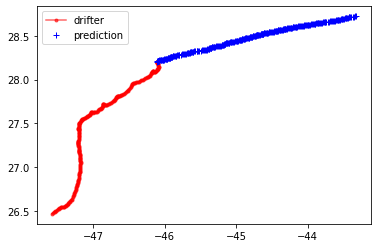

In [ ]:

geodesic = pyproj.Geod(ellps='WGS84')
fn='/content/drive/Shareddrives/Coastal/FFT challenge/data/data_up_to_14_Nov.csv'
d = pd.read_csv(fn)
idr = d['spotId']
k = 0 #choosen for prediction
df=d.loc[lambda d: d.spotId==idr.unique()[k],:]
print(idr.unique()[k])
x=-46.101820000000004
y=28.20502

dat=[]
dat.append((x,y))
for i in range(len(preds)-1):
  #update position
  dx = preds[i,0]
  dy = preds[i,1]
  #using geodetic shape to update the position of the artificial drifter
  di = np.sqrt(dx**2+dy**2)
  dir = np.arctan2(dx,dy)
  dir = dir*180/np.pi
  p2 = geodesic.fwd(x, y, dir, di) # to avoid the change lat!=lon!=Km
  x = p2[0]
  y = p2[1]
  dat.append((x,y))

dat = np.array(dat)
plt.plot(df.longitude.values,df.latitude.values,color='r',marker='.',label='drifter',alpha=0.6)
plt.plot(dat[:,0],dat[:,1],'b+',label='prediction',zorder=10)
plt.legend()
#df.plot.scatter(x='longitude',y='latitude',c='epoch [s]',title=idr[k])
print(k)

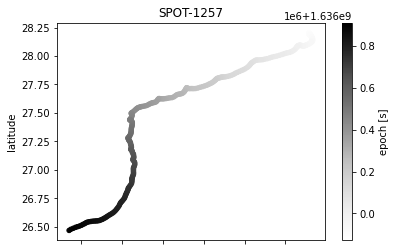

In [ ]:
fn='/content/drive/Shareddrives/Coastal/FFT challenge/data/data_up_to_14_Nov.csv'
d = pd.read_csv(fn)
idr = d['spotId']
k = 0 # index numbwer of drifter 0 to 89, total 90 drifters
df=d.loc[lambda d: d.spotId==idr.unique()[k],:]
df.plot.scatter(x='longitude',y='latitude',c='epoch [s]',title=idr[k])